Changes from v2

- implemented the possiblity to add nodes to the system
- add new visualization based data frame

**Importing Dependencies**

In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
# Probably not needed --> test ray lib instead
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v4 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [2]:
# Configuration of the network
# Sample JSON configuration (replace this with your JSON data)
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [3]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

In [4]:
list(env.graph.nodes())

['A', 'B', 'C', 'D', 'S']

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


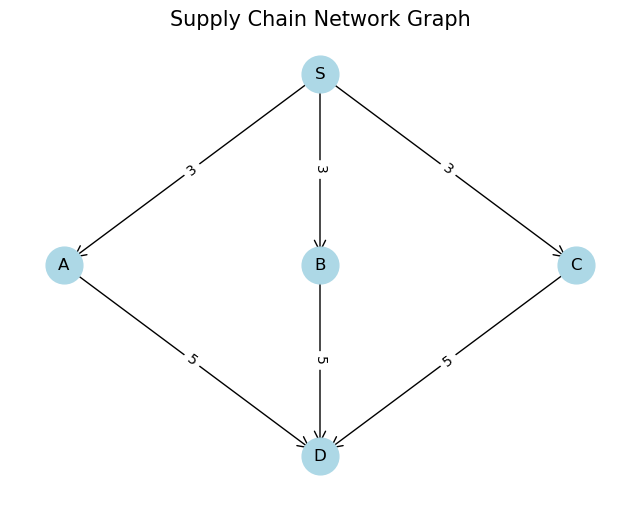

In [5]:
env.render_network()

In [6]:
env.order_queues

{'A': deque([0, 0, 0], maxlen=3),
 'B': deque([0, 0, 0], maxlen=3),
 'C': deque([0, 0, 0], maxlen=3)}

In [7]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [8]:
env.action_history

[array([0., 0., 0.])]

In [9]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # print('Step t:{} Score:{} Stock:{} Order:{} Delivered:{} Exp Demand t+3:{} Act Demand:{}'.format((EP_LENGTH - env.episode_length), score, n_state[0], action, env.delivered, n_state[1], env.demand))

        env.render()

    # print(env.order_history)

Episode Length: 1
Stock Level: [30. 28. 32.]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [40.11229  64.67859  21.487865]
Order: [0, 0, 0]
Reward: -45.0

Episode Length: 2
Stock Level: [18.65942826 18.24494103 19.73400058]
Planned Demand: [11.0736658   9.39445941  8.26391683]
Actual Demand: [11.34057174  9.75505897 12.26599942]
Action: [ 6.897932    0.17103255 56.01148   ]
Order: [0, 0, 0]
Reward: -73.31918493270045

Episode Length: 3
Stock Level: [ 1.99882033 18.24494103  4.00834129]
Planned Demand: [11.60067811  0.         10.83556383]
Actual Demand: [16.66060793  0.         15.72565928]
Action: [95.29928  15.291029 77.602005]
Order: [0, 0, 0]
Reward: -85.4452362583756

Episode Length: 4
Stock Level: [31.92552096 68.96465653 25.49620674]
Planned Demand: [ 7.73064767 11.65588784  0.        ]
Actual Demand: [10.1855888  13.95887337  0.        ]
Action: [44.802795 53.18201  77.09938 ]
Order: [40.11229, 64.67859, 21.487865]
Reward: -780.0321470934798

Episode Length: 5
St

**Train Model**


In [10]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')

In [11]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

env = DummyVecEnv([lambda: env])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [18]:
model.learn(total_timesteps=10000)

Logging to Training/Logs/PPO_29
-----------------------------
| time/              |      |
|    fps             | 5940 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 3355          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.6642793e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.94e+10      |
|    n_updates            | 500           |
|    policy_gradient_loss | -0.000269     |
|    std                  | 1             |
|    value

In [19]:
evaluate_policy(model, env, n_eval_episodes=1, render=False, return_episode_rewards=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([-9939.799438476562], [30])

In [20]:
df = pd.read_csv('./Data/2024-10-14_16_last_environment_data.csv')

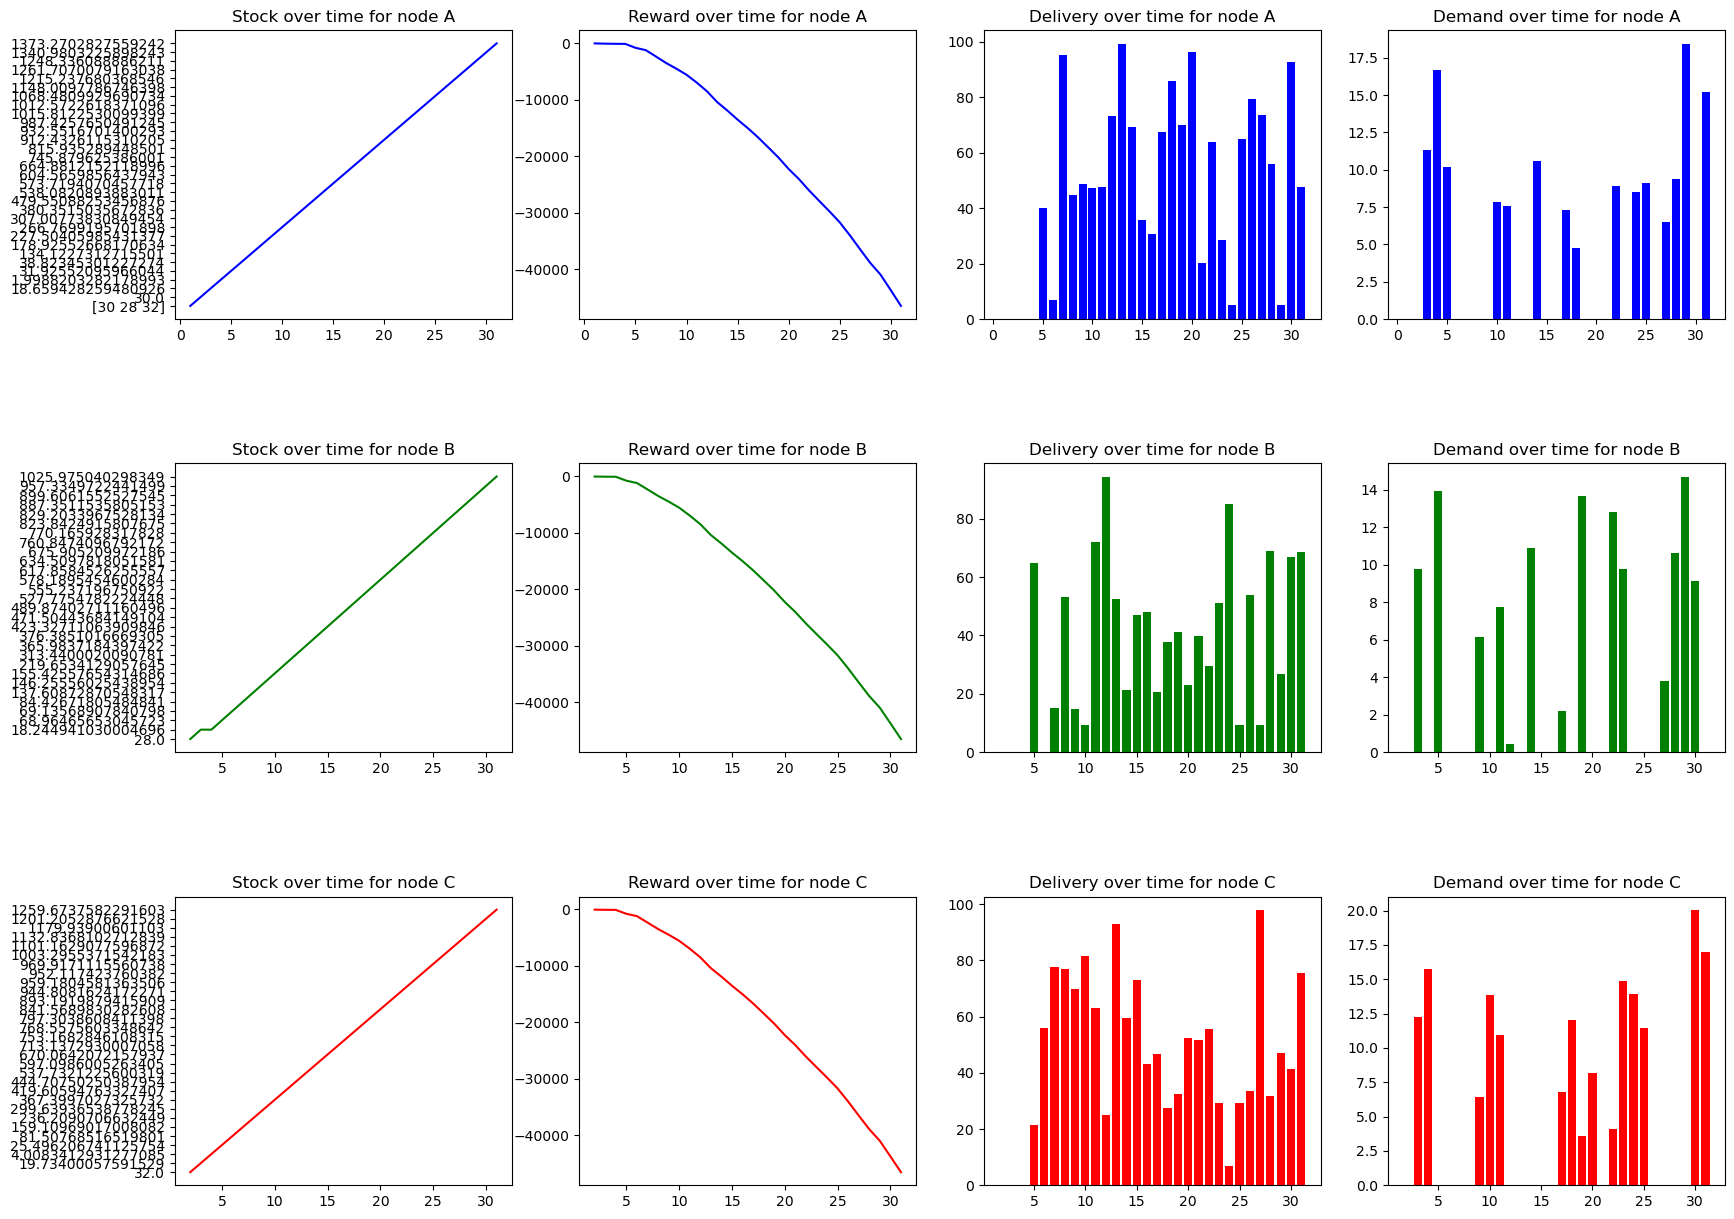

In [22]:
plot_data(df)